In [ ]:
from xml import etree
import os
import pickle
import pandas as pd
import glob
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from tensorflow import keras
import keras
#from tensorflow_addons.layers import ResNeXt50
from keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.models import Model
from keras.applications.inception_v3 import InceptionV3
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications import DenseNet121
from tqdm._tqdm_notebook import tqdm_notebook as tqdm
from google.colab import files
from sklearn.metrics import average_precision_score
from sklearn.multioutput import MultiOutputClassifier

<ipython-input-1-cce43d681e02>:24: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  from tqdm._tqdm_notebook import tqdm_notebook as tqdm


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
data_columns=['aeroplane','bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair',
       'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person',
       'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']

In [ ]:
#img_dir = 'C:/Users/SAMEER/Desktop/VOC2008/JPEGImages'
img_dir='/content/drive/MyDrive/VOC2008/JPEGImages'
input_size=(224,224)
input_shape=(224,224,3)
num_classes=20

In [ ]:
# path_for_images='C:\\Users\\SAMEER\\Desktop\\VOC2008\\JPEGImages\\'
path_for_images='/content/drive/MyDrive/VOC2008/JPEGImages'
img_files=glob.glob(os.path.join(path_for_images,'*.jpg'))
img_files=sorted(img_files)
print(img_files[:3])

# path_for_annotations='C:\\Users\\SAMEER\\Desktop\\VOC2008\\Annotations\\'
path_for_annotations='/content/drive/MyDrive/VOC2008/Annotations'
annot_files=glob.glob(os.path.join(path_for_annotations,'*.xml'))
annot_files=sorted(annot_files)
print(annot_files[:3])

['/content/drive/MyDrive/VOC2008/JPEGImages/2007_000027.jpg', '/content/drive/MyDrive/VOC2008/JPEGImages/2007_000032.jpg', '/content/drive/MyDrive/VOC2008/JPEGImages/2007_000033.jpg']
['/content/drive/MyDrive/VOC2008/Annotations/2007_000027.xml', '/content/drive/MyDrive/VOC2008/Annotations/2007_000032.xml', '/content/drive/MyDrive/VOC2008/Annotations/2007_000033.xml']


In [ ]:
def load_preprocess(img_path):
    img=load_img(img_path,target_size=input_shape)
    img=img_to_array(img)
    img/=255.
    return img

In [ ]:
def extract_bbox(files):
    i=0
    annotations =[]
    images=[]
    total_labels=[]
    
    for j in range(0,len(files)):


      # load and parse the file
      innerXml=etree.ElementTree.parse(files[j])
    
      # get root
      root=innerXml.getroot()

      width=int(root.find('.//size/width').text)
      height=int(root.find('.//size/height').text)
      objects=[]
      labels=[]
      name=(files[j].split('/',6))[-1]
      img_file=name.split('.')[0]+'.jpg'
      for box in root.findall('.//object'):
        label=box.find('name').text
        xmin=float(box.find('./bndbox/xmin').text)
        ymin=float(box.find('./bndbox/ymin').text)
        xmax=float(box.find('./bndbox/xmax').text)
        ymax=float(box.find('./bndbox/ymax').text)

        objects.append([xmin,ymin,xmax,ymax])
        labels.append(label)



      
      img_path= os.path.join(img_dir,img_file)
      img=load_preprocess(img_path)
      images.append(img)  
      annotations.append(objects)
      total_labels.append(labels)
    return annotations ,images,total_labels

In [ ]:
trainbox,trainimg,trainlab=extract_bbox(annot_files)

In [ ]:
def create_labels(data,df):
  index=0
  for labels in data:
    label=np.unique(labels).tolist()
    df.loc[index,label]=1
    lab=[i for i in data_columns if i not in label]
    df.loc[index,lab]=0
    #df.loc[index,'filename']=labels[1]
    index+=1
  
  return df

In [ ]:
train_Labels=pd.DataFrame(columns=data_columns)

In [ ]:
train_Labels=create_labels(trainlab,train_Labels)

In [ ]:
train_Labels[data_columns]=train_Labels[data_columns].astype(int)
train_Labels.head()

,aeroplane,bicycle,bird,boat,bottle,bus,car,cat,chair,cow,diningtable,dog,horse,motorbike,person,pottedplant,sheep,sofa,train,tvmonitor
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [ ]:
train_Labels.to_csv('Labels.csv',index=False)

In [ ]:
train_Labels=pd.read_csv('Labels.csv')
train_Labels.head(2)

,aeroplane,bicycle,bird,boat,bottle,bus,car,cat,chair,cow,diningtable,dog,horse,motorbike,person,pottedplant,sheep,sofa,train,tvmonitor
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [ ]:
#Pickling images
with open("trainImages", "wb") as fp:   
   pickle.dump(trainimg, fp)

#Pickling boundingboxes
with open("trainboxes", "wb") as fp:   #Pickling
   pickle.dump(trainbox, fp)

#Pickling labels
with open("trainlabels", "wb") as fp:   #Pickling
   pickle.dump(trainlab, fp)

# Object Detection

**Unpickling** **saved data**

In [ ]:
# Unpickling images
file = open('/content/drive/MyDrive/trainImages', 'rb')
trainimg = pickle.load(file)
file.close()

#Unpickling bounding boxes
file = open('/content/drive/MyDrive/trainboxes', 'rb')
trainbox = pickle.load(file)
file.close()

In [ ]:
# total_boxes=[]
# for box in trainbox:
#   arr=[]
#   for i in range(4):
#     arr.append(float(box[0][i]))
#   total_boxes.append(arr)

**Convert data to array**

In [ ]:
train_bb=np.asarray(total_boxes)
train_images = np.asarray(trainimg)
X_label = np.asarray(train_Labels)

**creating target output for models**

In [ ]:
trainTargets = {
	"class_label": X_label,
	"bounding_box": train_bb
}
# construct a second dictionary, this one for our target testing
# outputs
# testTargets = {
# 	"class_label": xtest_label,
# 	"bounding_box": test_bb1
# }

In [ ]:
losses = {
	"class_label": "binary_crossentropy",
	"bounding_box": "mean_squared_error",
}

**Helper function to create model**

In [ ]:
def get_detection_model(base):
  base.trainable=False

  flatten = base.output
  flatten = Flatten()(flatten)


  bboxHead = Dense(128, activation="relu")(flatten)
  bboxHead = Dense(64, activation="relu")(bboxHead)
  bboxHead = Dense(32, activation="relu")(bboxHead)
  bboxHead = Dense(4, activation="sigmoid",name="bounding_box")(bboxHead)


  # construct a second fully-connected layer head, this one to predict
  # the class label
  softmaxHead = Dense(512, activation="relu")(flatten)
  softmaxHead = Dropout(0.5)(softmaxHead)
  softmaxHead = Dense(512, activation="relu")(softmaxHead)
  softmaxHead = Dropout(0.5)(softmaxHead)
  softmaxHead = Dense(20, activation="sigmoid",
    name="class_label")(softmaxHead)

  # put together our model which accept an input image and then output
  # bounding box coordinates and a class label
  model = Model(
    inputs=base.input,
    outputs=(bboxHead, softmaxHead))
  model.summary()

  return model

**ResNet50**

In [ ]:
conv_base=ResNet50(weights='imagenet',
                  include_top=False,
                  input_shape=(224,224,3))
conv_base.summary()

94765736/94765736 [==============================] - 2s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                          

In [ ]:
model_resnet=get_detection_model(conv_base)
model_resnet.compile(loss=losses,
              optimizer=keras.optimizers.Adam(learning_rate=0.01),
              metrics=['accuracy'])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
history_resnet=model_resnet.fit(train_images,trainTargets,epochs=10 )

Epoch 1/10
160/160 [==============================] - 50s 202ms/step - loss: 72032.7578 - bounding_box_loss: 72031.8438 - class_label_loss: 0.9614 - bounding_box_accuracy: 0.0029 - class_label_accuracy: 0.1868
Epoch 2/10
160/160 [==============================] - 31s 191ms/step - loss: 72030.7031 - bounding_box_loss: 72030.3828 - class_label_loss: 0.2966 - bounding_box_accuracy: 0.0000e+00 - class_label_accuracy: 0.2086
Epoch 3/10
160/160 [==============================] - 31s 190ms/step - loss: 72030.6562 - bounding_box_loss: 72030.3828 - class_label_loss: 0.2528 - bounding_box_accuracy: 0.0000e+00 - class_label_accuracy: 0.2125
Epoch 4/10
160/160 [==============================] - 32s 198ms/step - loss: 72030.6406 - bounding_box_loss: 72030.3984 - class_label_loss: 0.2418 - bounding_box_accuracy: 0.0000e+00 - class_label_accuracy: 0.2125
Epoch 5/10
160/160 [==============================] - 34s 215ms/step - loss: 72030.6328 - bounding_box_loss: 72030.3984 - class_label_loss: 0.2368 -

**VGG16**

In [ ]:
conv_base=tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=input_shape
)

In [ ]:
model1=get_detection_model(conv_base)
model1.compile(loss=losses,
              optimizer=keras.optimizers.Adam(learning_rate=0.01),
              metrics=['accuracy'])

In [ ]:
h1=model1.fit(train_images,trainTargets,epochs=10)

# Classification

In [ ]:
class_label= {'person':0,'bird':1, 'cat':2, 'cow':3, 'dog':4, 'horse':5, 'sheep':6,'aeroplane':7, 'bicycle':8, 'boat':9, 'bus':10, 'car':11, 'motorbike':12, 'train':13 ,'bottle':14, 'chair':15, 'diningtable':16, 'pottedplant':17, 'sofa':18, 'tvmonitor':19}

In [ ]:
def load_model(name):
  file = open(name, 'rb')
  model = pickle.load(file)
  file.close()
  return model


In [ ]:
def save_model(model,name):
  with open(f"{name}.pkl", "wb") as fp1:   
   pickle.dump(model, fp1)
  files.download(f'{name}.pkl')

In [ ]:
def parse_xml(xml_path):
    tree = etree.ElementTree.parse(xml_path)
    root = tree.getroot()
    labels = np.zeros((20,), dtype=np.int32)
    for obj in root.findall('object'):
        label = obj.find('name').text
        label_idx = class_label[label]
        labels[label_idx]=1
        np.append(labels,label_idx)
    return labels

In [ ]:
images= []
total_labels=[]
count=0
img_path='/content/drive/MyDrive/VOC2008/JPEGImages'
anno_path='/content/drive/MyDrive/VOC2008/Annotations'
os.chdir('/content/drive/MyDrive/VOC2008/JPEGImages')
for i in tqdm(os.listdir()):
  img = cv2.imread(i)
  try:

    img = cv2.resize(img, (224,224))
    images.append(img)
    new_i = i.replace('.jpg','.xml')
    labels= parse_xml(anno_path +'/'+ new_i)
    total_labels.append(labels)
  except:
    count+=1
    print(count)
  # img = cv2.resize(img,(224,224)) 
  

  0%|          | 0/5104 [00:00<?, ?it/s]

1
2
3
4
5
6
7
8


In [ ]:
len(images)

994

In [ ]:
#Pickling images
save_model(images,'Images')
save_model(total_labels,'labels')

In [ ]:
xtrain,xtest,ytrain,ytest=train_test_split(images,total_labels,test_size=0.2)

In [ ]:
y_train = np.array(ytrain)
X_train = np.array(xtrain)
y_test = np.array(ytest)
X_test = np.array(xtest) 

In [ ]:
#Pickling images
with open("Image_to_train", "wb") as fp1:   
   pickle.dump(X_train, fp1)


#Pickling labels
with open("labels_to_train", "wb") as fp1:   #Pickling
   pickle.dump(y_train, fp1)

#Pickling images
with open("Image_to_test", "wb") as fp1:   
   pickle.dump(X_test, fp1)


#Pickling labels
with open("labels_to_test", "wb") as fp1:   #Pickling
   pickle.dump(y_test, fp1)

In [ ]:
# Unpickling images
file = open('/content/drive/MyDrive/Image_to_train', 'rb')
trainimages = pickle.load(file)
file.close()

file = open('/content/drive/MyDrive/Image_to_test', 'rb')
testimages = pickle.load(file)
file.close()

#Unpickling labels
file = open('/content/drive/MyDrive/labels_to_train', 'rb')
trainlabels = pickle.load(file)
file.close()

file = open('/content/drive/MyDrive/labels_to_test', 'rb')
testlabels = pickle.load(file)
file.close()


In [ ]:
len(X_train)

4076

In [ ]:
def get_classification_model(base):
  base.trainable=False

  flatten = base.output
  flatten = Flatten()(flatten)
  softmaxHead = Dense(256, activation="relu")(flatten)
  softmaxHead = Dropout(0.5)(softmaxHead)
  softmaxHead = Dense(128, activation="relu")(softmaxHead)
  softmaxHead = Dropout(0.5)(softmaxHead)
  softmaxHead = Dense(20, activation="sigmoid",
    name="class_label")(softmaxHead)

  # put together our model which accept an input image and then output
  # bounding box coordinates and a class label
  model = Model(
    inputs=base.input,
    outputs=(softmaxHead))
  model.summary()

  return model

In [ ]:
classes1= ['person','bird', 'cat', 'cow', 'dog', 'horse', 'sheep','aeroplane', 'bicycle', 'boat', 'bus', 'car',
              'motorbike', 'train' ,'bottle', 'chair', 'diningtable', 'pottedplant', 'sofa', 'tvmonitor']

In [ ]:
def makePrediction(model,img):
  yPred = model.predict(np.expand_dims(img,axis=0))
  classes = np.array(classes1) #Get array of all classes
  sorted_categories = np.argsort(yPred[0])[:-11:-1]  #Get class names for top 10 categories

  #Print classes and corresponding probabilities
  for i in range(10):
    print("{}".format(classes[sorted_categories[i]])+" ({:.3})".format(yPred[0][sorted_categories[i]]))



**Inceptionv3**

In [ ]:
inception=InceptionV3(weights='imagenet',include_top=False,input_shape=input_shape)
model1=get_classification_model(inception)

87910968/87910968 [==============================] - 7s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                  

In [ ]:
model1.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.Adam(learning_rate=0.01),
              metrics=['accuracy'])
history1=model1.fit(trainimages,trainlabels,validation_data=(testimages,testlabels),epochs=10)

Epoch 1/10
128/128 [==============================] - 31s 134ms/step - loss: 33.0713 - accuracy: 0.4095 - val_loss: 0.3506 - val_accuracy: 0.5000
Epoch 2/10
128/128 [==============================] - 11s 86ms/step - loss: 0.3614 - accuracy: 0.4926 - val_loss: 0.2656 - val_accuracy: 0.5000
Epoch 3/10
128/128 [==============================] - 11s 82ms/step - loss: 0.3080 - accuracy: 0.4948 - val_loss: 0.2433 - val_accuracy: 0.5000
Epoch 4/10
128/128 [==============================] - 11s 84ms/step - loss: 0.2684 - accuracy: 0.4941 - val_loss: 0.2362 - val_accuracy: 0.5000
Epoch 5/10
128/128 [==============================] - 12s 91ms/step - loss: 0.2877 - accuracy: 0.4946 - val_loss: 0.2337 - val_accuracy: 0.5000
Epoch 6/10
128/128 [==============================] - 11s 85ms/step - loss: 0.2457 - accuracy: 0.4948 - val_loss: 0.2327 - val_accuracy: 0.5000
Epoch 7/10
128/128 [==============================] - 11s 89ms/step - loss: 0.3153 - accuracy: 0.4948 - val_loss: 0.2324 - val_accurac

In [ ]:
makePrediction(model1,testimages[409])

1/1 [==============================] - 5s 5s/step
person (0.485)
car (0.119)
chair (0.0955)
dog (0.0912)
cat (0.0737)
bird (0.0697)
tvmonitor (0.062)
bottle (0.0615)
aeroplane (0.0583)
sofa (0.0524)


Text(0.5, 1.0, '[1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0]')

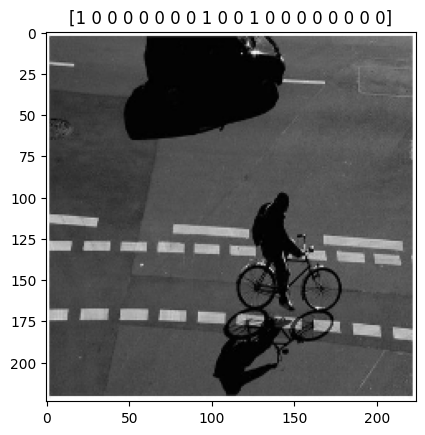

In [ ]:
plt.imshow(testimages[409])
plt.title(f'{testlabels[409]}')

In [ ]:
save_model(model1,'inception')

**ResNet50**

In [ ]:
resnet=ResNet50(weights='imagenet',
                  include_top=False,
                  input_shape=input_shape)
model2=get_classification_model(resnet)

94765736/94765736 [==============================] - 5s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                           

In [ ]:
model2.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.Adam(learning_rate=0.01),
              metrics=['accuracy'])
history2=model2.fit(trainimages,trainlabels,validation_data=(testimages,testlabels),epochs=5)

Epoch 1/5
128/128 [==============================] - 25s 158ms/step - loss: 2.4027 - accuracy: 0.4389 - val_loss: 0.2452 - val_accuracy: 0.5078
Epoch 2/5
128/128 [==============================] - 19s 150ms/step - loss: 0.7738 - accuracy: 0.4875 - val_loss: 0.2427 - val_accuracy: 0.5069
Epoch 3/5
128/128 [==============================] - 18s 142ms/step - loss: 0.6511 - accuracy: 0.4836 - val_loss: 0.2411 - val_accuracy: 0.4980
Epoch 4/5
128/128 [==============================] - 18s 142ms/step - loss: 0.6523 - accuracy: 0.4909 - val_loss: 0.2527 - val_accuracy: 0.4951
Epoch 5/5
128/128 [==============================] - 18s 142ms/step - loss: 0.7178 - accuracy: 0.4912 - val_loss: 0.2657 - val_accuracy: 0.4941


In [ ]:
save_model(model2,'resnet')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**VGG16**

In [ ]:
vgg16=tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=input_shape
)
model3=get_classification_model(vgg16)

58889256/58889256 [==============================] - 3s 0us/step
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [ ]:
model3.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.Adam(learning_rate=0.01),
              metrics=['accuracy'])
history3=model3.fit(trainimages,trainlabels,validation_data=(testimages,testlabels),epochs=5)

Epoch 1/5
128/128 [==============================] - 36s 238ms/step - loss: 3.0747 - accuracy: 0.4065 - val_loss: 0.2970 - val_accuracy: 0.5108
Epoch 2/5
128/128 [==============================] - 23s 177ms/step - loss: 1.0132 - accuracy: 0.4674 - val_loss: 0.2701 - val_accuracy: 0.5000
Epoch 3/5
128/128 [==============================] - 22s 173ms/step - loss: 0.6967 - accuracy: 0.4845 - val_loss: 0.2408 - val_accuracy: 0.5000
Epoch 4/5
128/128 [==============================] - 22s 175ms/step - loss: 0.5166 - accuracy: 0.4899 - val_loss: 0.2346 - val_accuracy: 0.5000
Epoch 5/5
128/128 [==============================] - 22s 172ms/step - loss: 0.5017 - accuracy: 0.4917 - val_loss: 0.2330 - val_accuracy: 0.5000


In [ ]:
save_model(model2,'vgg16')

**MobileNet**

In [ ]:
mobilenet = MobileNetV2(
    input_shape=input_shape,
    weights='imagenet', 
    include_top=False)
model4=get_classification_model(mobilenet)

9406464/9406464 [==============================] - 1s 0us/step
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                             

In [ ]:
model4.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.Adam(learning_rate=0.01),
              metrics=['accuracy'])
history4=model4.fit(trainimages,trainlabels,validation_data=(testimages,testlabels),epochs=5)

Epoch 1/5
128/128 [==============================] - 12s 66ms/step - loss: 1.4632 - accuracy: 0.3928 - val_loss: 0.2334 - val_accuracy: 0.5000
Epoch 2/5
128/128 [==============================] - 6s 50ms/step - loss: 0.2611 - accuracy: 0.4948 - val_loss: 0.2332 - val_accuracy: 0.5000
Epoch 3/5
128/128 [==============================] - 7s 51ms/step - loss: 0.2487 - accuracy: 0.4948 - val_loss: 0.2323 - val_accuracy: 0.5000
Epoch 4/5
128/128 [==============================] - 6s 49ms/step - loss: 0.2568 - accuracy: 0.4956 - val_loss: 0.2325 - val_accuracy: 0.5000
Epoch 5/5
128/128 [==============================] - 7s 51ms/step - loss: 0.2449 - accuracy: 0.4951 - val_loss: 0.2321 - val_accuracy: 0.5000


In [ ]:
save_model(model4,'mobilenet')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**DenseNet**

In [ ]:
dense = DenseNet121(
    input_shape=input_shape, 
    weights='imagenet', 
    include_top=False)
model5=get_classification_model(dense)

29084464/29084464 [==============================] - 2s 0us/step
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_5[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                           

In [ ]:
model5.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.Adam(learning_rate=0.01),
              metrics=['accuracy'])
history5=model5.fit(trainimages,trainlabels,validation_data=(testimages,testlabels),epochs=5)

Epoch 1/5
128/128 [==============================] - 30s 163ms/step - loss: 5.6840 - accuracy: 0.4316 - val_loss: 0.2540 - val_accuracy: 0.5000
Epoch 2/5
128/128 [==============================] - 18s 137ms/step - loss: 0.2816 - accuracy: 0.4948 - val_loss: 0.2334 - val_accuracy: 0.5000
Epoch 3/5
128/128 [==============================] - 16s 122ms/step - loss: 0.3021 - accuracy: 0.4941 - val_loss: 0.2325 - val_accuracy: 0.5000
Epoch 4/5
128/128 [==============================] - 18s 138ms/step - loss: 0.2585 - accuracy: 0.4953 - val_loss: 0.2322 - val_accuracy: 0.5000
Epoch 5/5
128/128 [==============================] - 15s 118ms/step - loss: 0.3068 - accuracy: 0.4956 - val_loss: 0.2322 - val_accuracy: 0.5000


**With softmax**

In [ ]:
def getModel(base):
  base.trainable=False

  flatten = base.output
  flatten = Flatten()(flatten)
  softmaxHead = Dense(256, activation="relu")(flatten)
  softmaxHead = Dropout(0.5)(softmaxHead)
  softmaxHead = Dense(128, activation="relu")(softmaxHead)
  softmaxHead = Dropout(0.5)(softmaxHead)
  softmaxHead = Dense(20, activation="softmax",
    name="class_label")(softmaxHead)

  # put together our model which accept an input image and then output
  # bounding box coordinates and a class label
  model = Model(
    inputs=base.input,
    outputs=(softmaxHead))
  model.summary()

  return model

In [ ]:
resnet1=ResNet50(weights='imagenet',
                  include_top=False,
                  input_shape=input_shape)
resmodel=getModel(resnet1)

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_6[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [ ]:
resmodel.compile(loss="categorical_crossentropy",
              optimizer=keras.optimizers.Adam(learning_rate=0.01),
              metrics=['accuracy'])
hist=resmodel.fit(trainimages,trainlabels,validation_data=(testimages,testlabels),epochs=5)

Epoch 1/5
128/128 [==============================] - 22s 150ms/step - loss: 3071628.7500 - accuracy: 0.2576 - val_loss: 13098902.0000 - val_accuracy: 0.5000
Epoch 2/5
128/128 [==============================] - 18s 142ms/step - loss: 50704404.0000 - accuracy: 0.2414 - val_loss: 96188040.0000 - val_accuracy: 0.0735
Epoch 3/5
128/128 [==============================] - 18s 141ms/step - loss: 197924304.0000 - accuracy: 0.2402 - val_loss: 358197504.0000 - val_accuracy: 0.5000
Epoch 4/5
128/128 [==============================] - 18s 142ms/step - loss: 460507040.0000 - accuracy: 0.2412 - val_loss: 461466656.0000 - val_accuracy: 0.5000
Epoch 5/5
128/128 [==============================] - 18s 139ms/step - loss: 800551232.0000 - accuracy: 0.2323 - val_loss: 696531136.0000 - val_accuracy: 0.5000


**Mean average precision**

# Early and Late fusion

In [ ]:
def extract_features(model, img):
    x = np.expand_dims(img, axis=0)
    #x = preprocess_fn(x)
    features = model.predict(x)
    return features.flatten()

**Second way**

In [ ]:
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Concatenate

# Define input shape
input_shape = (224, 224, 3)

# Define input tensor
input_tensor = Input(shape=input_shape)


In [ ]:
feat1 = inception.layers[-2].output
feat2 = resnet.layers[-2].output
feat3 = vgg16.layers[-1].output
feat4 = mobilenet.layers[-2].output
feat5 = dense.layers[-2].output

In [ ]:
feat1 = GlobalAveragePooling2D()(feat1)
feat2 = GlobalAveragePooling2D()(feat2)
feat3 = GlobalAveragePooling2D()(feat3)
feat4 = GlobalAveragePooling2D()(feat4)
feat5 = GlobalAveragePooling2D()(feat5)

In [ ]:
X_train1 = Concatenate()([feat1, feat2, feat3, feat4, feat5])

In [ ]:
X_train1.shape

TensorShape([None, 5056])

In [ ]:
out1 = Dense(256, activation='relu')(X_train1)
x = Dense(num_classes, activation='softmax')(out1)

In [ ]:
model = Model(inputs=input_tensor, outputs=x)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

ValueError: ignored

In [ ]:

training_data = tf.keras.layers.concatenate([inception.layers[-2].output,
          resnet.layers[-2].output,
          model3.get_layer('block5_pool').output,
          mobilenet.layers[-2].output, 
          dense.layers[-2].output])

ValueError: ignored

**One way**

In [ ]:
# Extract features

inception_features_model = Model(inputs=model1.input, outputs=model1.layers[-2].output)

resnet_features_model = Model(inputs=model2.input, outputs=model2.layers[-2].output)


vgg_features_model = Model(inputs=model3.input, outputs=model3.get_layer('block5_pool').output)

mobilenet_features_model = Model(inputs=model4.input, outputs=model4.layers[-2].output)

densenet_features_model = Model(inputs=model5.input, outputs=model5.layers[-2].output)


In [ ]:
models=[vgg_features_model,
          resnet_features_model,
          inception_features_model,
          densenet_features_model, mobilenet_features_model]

In [ ]:
Xtrain_features=[]
ytrain_features=[]
for i in range(0,len(trainimages)):
  img = trainimages[i]
  label = trainlabels[i]
  features = []
  for model in models:

    model_features = extract_features(model, img)
    features.append(model_features)
  Xtrain_features.append(np.concatenate(features))
  ytrain_features.append(label)

save_model(Xtrain_features,'training_features2')
save_model(ytrain_features,'trainlabels_feaures2')

1/1 [==============================] - 3s 3s/step


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 94ms/step


NameError: ignored

In [ ]:
trainimages2=load_model('/content/drive/MyDrive/training_features2.pkl')
trainlabels2=load_model('/content/drive/MyDrive/trainlabels_feaures2.pkl')

In [ ]:
xtrain=np.array(trainimages2)
ytrain=np.array(trainlabels2)

In [ ]:
print(xtrain.shape)
print(ytrain.shape)

(4076, 25600)
(4076, 20)


In [ ]:
from sklearn.svm import SVC

In [ ]:
Xtrain,Xval,Ytrain,Yval=train_test_split(xtrain,ytrain,test_size=0.2)

In [ ]:
svm = SVC(kernel='rbf')
#svm.fit(X_train_reshaped, y_train)

In [ ]:
multilabel_classifier = MultiOutputClassifier(svm, n_jobs=-1)

# Fit the data to the Multilabel classifier
multilabel_classifier = multilabel_classifier.fit(Xtrain, Ytrain)

In [ ]:
save_model(multilabel_classifier,'rbf_svm')

In [ ]:
Y_pred=multilabel_classifier.predict(Xval)

In [ ]:
multilabel_classifier.score(Xtrain,Ytrain)

In [ ]:
fil

FC network

In [ ]:
Fc_model = Sequential([
    Flatten(input_shape=Xtrain.shape[1:]),
    Dense(512, activation='relu'),
    Dense(num_classes, activation='sigmoid')
])

Fc_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
Fc_model.fit(Xtrain,Ytrain, batch_size=32, validation_data=(Xval,Yval),epochs=10)

Epoch 1/10
102/102 [==============================] - 3s 11ms/step - loss: 1.7403 - accuracy: 0.6061 - val_loss: 0.3847 - val_accuracy: 0.6299
Epoch 2/10
102/102 [==============================] - 1s 9ms/step - loss: 0.2321 - accuracy: 0.7255 - val_loss: 0.4012 - val_accuracy: 0.6912
Epoch 3/10
102/102 [==============================] - 1s 8ms/step - loss: 0.1183 - accuracy: 0.7834 - val_loss: 0.4353 - val_accuracy: 0.7157
Epoch 4/10
102/102 [==============================] - 1s 8ms/step - loss: 0.0685 - accuracy: 0.7939 - val_loss: 0.4944 - val_accuracy: 0.7047
Epoch 5/10
102/102 [==============================] - 1s 8ms/step - loss: 0.0414 - accuracy: 0.8025 - val_loss: 0.5309 - val_accuracy: 0.7525
Epoch 6/10
102/102 [==============================] - 1s 7ms/step - loss: 0.0294 - accuracy: 0.8021 - val_loss: 0.5464 - val_accuracy: 0.6961
Epoch 7/10
102/102 [==============================] - 1s 7ms/step - loss: 0.0220 - accuracy: 0.8095 - val_loss: 0.5605 - val_accuracy: 0.7426
Epoch

**Late fusion**

In [ ]:
models1=[model1,model2,model3,model4,model5]

In [ ]:
models_pred=[]
for model in models1:
  features=[]
  for i in range(0,len(testimages)):
    img = testimages[i]
    model_features = extract_features(model, img)
    features.append((model_features))
  models_pred.append(features)

In [ ]:
save_model(models_pred,'model_predictions')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
modelPredictions=load_model('/content/drive/MyDrive/model_predictions.pkl')

In [ ]:
model1pred = np.argmax(model1.predict(testimages), axis=1)
model2pred = np.argmax(model2.predict(testimages), axis=1)
model3pred = np.argmax(model3.predict(testimages), axis=1)
model4pred = np.argmax(model4.predict(testimages), axis=1)
model5pred = np.argmax(model5.predict(testimages), axis=1)

32/32 [==============================] - 5s 94ms/step


In [ ]:
majority_vote = []
for i in range(len(testimages)):
    preds = [model1pred[i], model2pred[i], model3pred[i], model4pred[i], model5pred[i]]
    majority_vote.append(max(set(preds),key=preds.count))

In [ ]:
avg_fusion = np.round(np.mean([model1pred, model2pred, model3pred,
                                     model4pred, model5pred], axis=0))

In [ ]:
models_pred=[model1pred,model2pred,model3pred,model4pred,model5pred]

In [ ]:
max = np.max(models_pred, axis=0)
min = np.min(models_pred, axis=0)

In [ ]:
model_names=['InceptionV3','ResNet50','VGG16','MobileNetv2','DenseNet121']
for pred,name in zip(modelPredictions,model_names):
  mAP=average_precision_score(testlabels,pred)
  print(f'{name}: {mAP}')


InceptionV3: 0.07686274509803923
ResNet50: 0.07686274509803923
VGG16: 0.07686274509803923
MobileNetv2: 0.07686274509803923
DenseNet121: 0.07686274509803923


In [ ]:
len(modelPredictions)

5